In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path

# --- CUSTOM IMPORTS (Your new Source Files) ---
# Ensure your src folder has __init__.py, data_loader.py, and hqcnn_model.py
import sys
sys.path.append('../') # Adds the parent directory to path so we can find 'src'

from src.data_loader import get_data_loaders
from src.hqcnn_model import HQCNN

# --- CONFIGURATION FOR Q1 JOURNAL EXPERIMENT ---
# We use 15 epochs and 20% data to prove "Rapid Convergence & Efficiency"
BATCH_SIZE = 32
EPOCHS = 15             
LEARNING_RATE = 0.0004  
PERCENT_DATA = 0.20     # Use 20% of data (approx 7,800 images)

# --- PATH SETUP ---
# Automatically finds the data folder relative to this notebook
DATA_DIR = Path('../data/GTSRB')

# --- DEVICE SETUP ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"🚀 SYSTEM ONLINE")
print(f"   • Device:      {DEVICE}")
print(f"   • Data Path:   {DATA_DIR.resolve()}")
print(f"   • Experiment:  Quantum Transfer Learning (Efficiency Test)")

🚀 SYSTEM ONLINE
   • Device:      cuda:0
   • Data Path:   /home/akash_kishore/HQCNN_Project/data/GTSRB
   • Experiment:  Quantum Transfer Learning (Efficiency Test)


In [2]:
print(f"⏳ Loading {PERCENT_DATA*100}% of the GTSRB Dataset...")

try:
    train_loader, val_loader = get_data_loaders(
        data_dir=str(DATA_DIR), 
        batch_size=BATCH_SIZE, 
        percent=PERCENT_DATA
    )
    print("✅ Data Loaded Successfully.")
except FileNotFoundError as e:
    print(f"❌ ERROR: {e}")
    print("   -> Please check that your 'data/GTSRB' folder contains 'Train.csv' and the 'train' folder.")

⏳ Loading 20.0% of the GTSRB Dataset...
✂️ SLICING DATA: Reduced dataset to 7841 images (20.0%)
✅ DATA READY: 6664 Train | 1177 Val
✅ Data Loaded Successfully.


In [3]:
# Initialize the Hybrid Quantum-ResNet
model = HQCNN(n_classes=43).to(DEVICE)

# Define Loss Function (CrossEntropy is standard for classification)
criterion = nn.CrossEntropyLoss()

# Define Optimizer
# CRITICAL: We only optimize parameters that have requires_grad=True
# (This means we are optimizing the Quantum Weights & Classifier, but NOT the ResNet eyes)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=LEARNING_RATE
)

# Define Scheduler
# If Validation Loss stops dropping for 2 epochs, reduce Learning Rate by 10x
# This helps the model "settle" into the global minimum.
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, verbose=True
)

print("🧠 Hybrid Model Initialized:")
print("   • Backbone:    ResNet18 (Pre-trained & Frozen)")
print("   • Head:        Variational Quantum Circuit (4 Qubits)")

🧠 Initializing Hybrid ResNet18 Backbone...


/home/akash_kishore/miniconda3/envs/hqcnn_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akash_kishore/miniconda3/envs/hqcnn_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/akash_kishore/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


🧠 Hybrid Model Initialized:
   • Backbone:    ResNet18 (Pre-trained & Frozen)
   • Head:        Variational Quantum Circuit (4 Qubits)


/home/akash_kishore/miniconda3/envs/hqcnn_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    
    # Store history for plotting
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    best_model_wts =  model.state_dict()
    best_acc = 0.0

    print(f"\n🔥 STARTING TRAINING ({num_epochs} Epochs)...")
    print("-" * 65)
    print(f"{'Epoch':<8} | {'Time':<6} | {'Train Acc':<10} | {'Val Acc':<10} | {'Val Loss':<10}")
    print("-" * 65)

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # --- TRAIN PHASE ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)

        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        
        # Calculate Epoch Time
        epoch_time = time.time() - epoch_start

        # --- UPDATES ---
        scheduler.step(val_loss) # Adjust LR if needed
        
        # Print stats
        print(f"{epoch+1}/{num_epochs:<6} | {epoch_time:.0f}s    | {epoch_acc*100:.2f}%      | {val_acc*100:.2f}%      | {val_loss:.4f}")

        # Deep Copy Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), 'best_hqcnn_qtl.pth')
            
        # Store history
        history['train_acc'].append(epoch_acc.item())
        history['val_acc'].append(val_acc.item())
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)

    time_elapsed = time.time() - since
    print("-" * 65)
    print(f'🏆 TRAINING COMPLETE in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🥇 Best Validation Acc: {best_acc*100:.2f}%')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# --- RUN EXECUTION ---
model_trained, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)


🔥 STARTING TRAINING (15 Epochs)...
-----------------------------------------------------------------
Epoch    | Time   | Train Acc  | Val Acc    | Val Loss  
-----------------------------------------------------------------
1/15     | 41s    | 18.89%      | 36.02%      | 3.0667
2/15     | 32s    | 39.24%      | 44.77%      | 2.8211
3/15     | 33s    | 46.56%      | 50.81%      | 2.6130
4/15     | 32s    | 51.49%      | 52.68%      | 2.4582
5/15     | 31s    | 56.11%      | 55.56%      | 2.3146
6/15     | 31s    | 57.04%      | 56.67%      | 2.1897
7/15     | 31s    | 57.02%      | 55.40%      | 2.1126
8/15     | 31s    | 58.06%      | 56.16%      | 2.0366
9/15     | 27s    | 59.14%      | 56.84%      | 1.9385
10/15     | 31s    | 58.69%      | 57.86%      | 1.8567
11/15     | 31s    | 58.75%      | 56.41%      | 1.7897
12/15     | 31s    | 58.52%      | 56.33%      | 1.7409
13/15     | 37s    | 58.87%      | 56.75%      | 1.7010
14/15     | 34s    | 59.17%      | 57.77%      | 1.6428


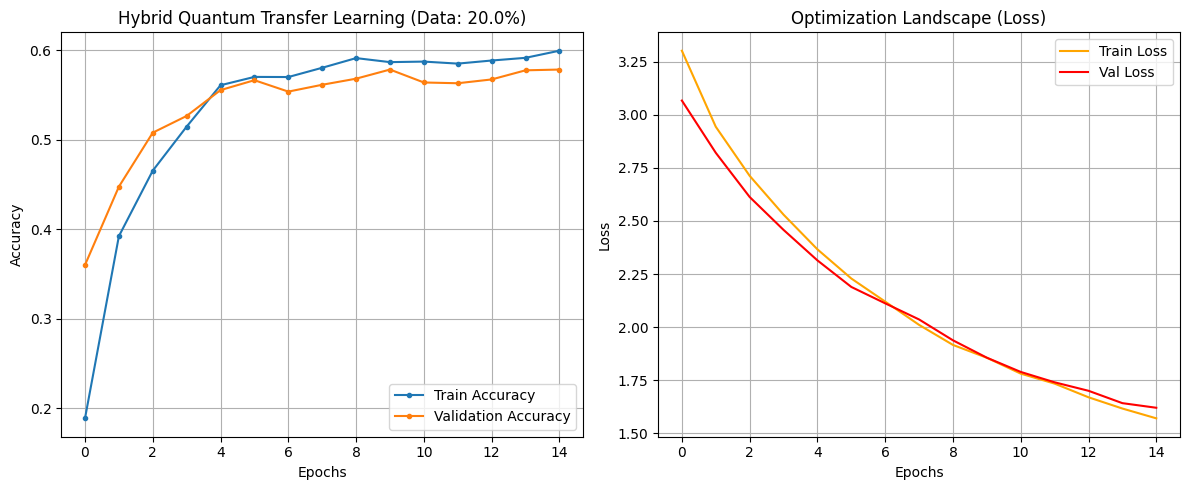

In [5]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy', marker='.')
plt.plot(history['val_acc'], label='Validation Accuracy', marker='.')
plt.title(f'Hybrid Quantum Transfer Learning (Data: {PERCENT_DATA*100}%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', color='orange')
plt.plot(history['val_loss'], label='Val Loss', color='red')
plt.title('Optimization Landscape (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_qtl.png') # Save for the paper!
plt.show()